In [32]:
# ==============================================================================
# 셀 1: [SETUP] 라이브러리 임포트 및 경로 설정
# ==============================================================================
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta # 추천 시스템용

# --- 경고 메시지 무시 ---
warnings.filterwarnings('ignore')

# --- 한글 폰트 설정 (윈도우 기준) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# --- 1. [경로] 원본 데이터 폴더 ---
DATA_FOLDER = os.path.join("..", "official_data_s")

# [공급] 주차장 원본
SUPPLY_CSV_PATH = os.path.join(DATA_FOLDER, "주차장정보현황(제공표준).csv")

# [수요] 생활인구 원본
DEMAND_EXCEL_PATH = os.path.join(DATA_FOLDER, "1_생활인구분석_LG유플러스.xlsx")
DEMAND_SHEET_NAME = "33,34p 행정동별 시간대별 생활인구"

# [확장1] 관광객 원본
TOURISM_EXCEL_PATH = os.path.join(DATA_FOLDER, "3_관광지분석_LG유플러스.xlsx")
TOURISM_SHEET_NAME = '15p_27p_39p_51p_63p_시간대별'

# [확장2] 상권(매출) 원본
SALES_EXCEL_PATH = os.path.join(DATA_FOLDER, "5_식품위생업소소비분석_삼성카드.xlsx")
SALES_SHEET_NAME = '17,18p 행정동별 시간대별 매출액'

# [검증] 지역활력지수 원본
VITALITY_EXCEL_PATH = os.path.join(DATA_FOLDER, "6_소비경제규모추정.xlsx")
VITALITY_SHEET_NAME = '13~14p 지역활력지수'

# --- 2. [경로] 산출물 저장 폴더 및 파일명 ---
# (분석 중간 단계의 데이터를 저장할 폴더)
NORMALIZATION_FOLDER = "normalization"
os.makedirs(NORMALIZATION_FOLDER, exist_ok=True)

# [경로] 중간 데이터 파일명
V1_CSV = os.path.join(NORMALIZATION_FOLDER, "parking_congestion_index_v1_base.csv")
V2_CSV = os.path.join(NORMALIZATION_FOLDER, "parking_congestion_index_v2_tourism.csv")
V3_CSV = os.path.join(NORMALIZATION_FOLDER, "parking_congestion_index_v3_final.csv")
FINAL_LOTS_CSV = os.path.join(NORMALIZATION_FOLDER, "parking_lots_with_congestion_v3.csv")

print("--- 1. [SETUP] 라이브러리, 경로, 폴더 설정 완료 ---")

--- 1. [SETUP] 라이브러리, 경로, 폴더 설정 완료 ---


In [33]:
# ==============================================================================
# 셀 2: [DATA LOAD] 모든 원본 데이터 로드
# ==============================================================================
try:
    # 1. [공급] 주차장 정보 (df_supply_raw)
    df_supply_raw = pd.read_csv(SUPPLY_CSV_PATH, encoding='cp949')
    print(f"--- [공급] 원본 주차장 로드: {len(df_supply_raw)} 행")

    # 2. [수요] 생활인구 (df_demand_raw)
    df_demand_raw = pd.read_excel(DEMAND_EXCEL_PATH, 
                                  sheet_name=DEMAND_SHEET_NAME, 
                                  engine='openpyxl')
    print(f"--- [수요] 원본 생활인구 로드: {len(df_demand_raw)} 행")

    # 3. [확장1] 관광객 (df_tourism_raw)
    df_tourism_raw = pd.read_excel(TOURISM_EXCEL_PATH,
                                   sheet_name=TOURISM_SHEET_NAME,
                                   engine='openpyxl')
    print(f"--- [확장1] 원본 관광객 로드: {len(df_tourism_raw)} 행")

    # 4. [확장2] 상권(매출) (df_sales_raw)
    df_sales_raw = pd.read_excel(SALES_EXCEL_PATH,
                                 sheet_name=SALES_SHEET_NAME,
                                 engine='openpyxl')
    print(f"--- [확장2] 원본 상권매출 로드: {len(df_sales_raw)} 행")
    
    # 5. [검증] 지역활력지수 (df_vitality_raw)
    df_vitality_raw = pd.read_excel(VITALITY_EXCEL_PATH,
                                    sheet_name=VITALITY_SHEET_NAME,
                                    engine='openpyxl')
    print(f"--- [검증] 원본 활력지수 로드: {len(df_vitality_raw)} 행")

except ImportError:
    print("\n!!! [오류] 'openpyxl' 라이브러리가 필요합니다.")
    print(">>> 터미널(Terminal)을 열고 'pip install openpyxl' 을 실행한 뒤 커널(Kernel)을 재시작해주세요.")
except Exception as e:
    print(f"\n!!! [오류] 파일 로드 실패 !!! \n{e}")

print("\n--- 2. [DATA LOAD] 모든 원본 데이터 로드 완료 ---")

--- [공급] 원본 주차장 로드: 92 행
--- [수요] 원본 생활인구 로드: 80 행
--- [확장1] 원본 관광객 로드: 120 행
--- [확장2] 원본 상권매출 로드: 20 행
--- [검증] 원본 활력지수 로드: 20 행

--- 2. [DATA LOAD] 모든 원본 데이터 로드 완료 ---


In [34]:
# ==============================================================================
# 셀 3: [V1] "슈퍼 그룹" 매핑 및 혼잡예상지수 v1(기반) 생성
# ==============================================================================

# --- 1. [핵심] "슈퍼 그룹" 매핑 딕셔너리 정의 ---
# [공급] 법정동(읍면동) -> 슈퍼 그룹
supply_map = {
    '광탄면': '광탄면', '문산읍': '문산읍', '법원읍': '법원읍', '월롱면': '월롱면',
    '적성면': '적성면', '조리읍': '조리읍', '탄현면': '탄현면', '파주읍': '파주읍', '파평면': '파평면',
    '금촌동': '금촌', '금릉동': '금촌', '아동동': '금촌', '신촌동': '금촌',
    '다율동': '운정', '동패동': '운정', '목동동': '운정', '야당동': '운정', '와동동': '운정',
    '문발동': '교하동', '서패동': '교하동', 
    '진동면': np.nan # 분석 제외
}

# [수요] 행정동 -> 슈퍼 그룹 (이 demand_map은 다른 데이터 처리에도 계속 사용됨)
demand_map = {
    '광탄면': '광탄면', '문산읍': '문산읍', '법원읍': '법원읍', '월롱면': '월롱면',
    '적성면': '적성면', '조리읍': '조리읍', '탄현면': '탄현면', '파주읍': '파주읍', '파평면': '파평면',
    '교하동': '교하동',
    '금촌1동': '금촌', '금촌2동': '금촌', '금촌3동': '금촌',
    '운정1동': '운정', '운정2동': '운정', '운정3동': '운정', '운정4동': '운정', '운정5동': '운정', '운정6동': '운정',
    '장단면': np.nan # 분석 제외
}

# --- 2. [공급] 데이터 집계 (v1) ---
df_supply = df_supply_raw.dropna(subset=['소재지지번주소']).copy()
df_supply['읍면동_추출'] = df_supply['소재지지번주소'].apply(lambda x: x.split(' ')[2])
df_supply['행정구역_그룹'] = df_supply['읍면동_추출'].map(supply_map)
df_supply_grouped = df_supply.dropna(subset=['행정구역_그룹'])
df_supply_final = df_supply_grouped.groupby('행정구역_그룹')['주차구획수'].sum().reset_index()
df_supply_final = df_supply_final.rename(columns={'주차구획수': '총_주차면수'})
print(f"--- [공급] v1 (총 주차면수) 집계 완료: {len(df_supply_final)} 그룹")

# --- 3. [수요] 데이터 집계 (v1) ---
df_demand = df_demand_raw.copy()
df_demand['행정구역_그룹'] = df_demand['행정동'].map(demand_map)
df_demand_grouped = df_demand.dropna(subset=['행정구역_그룹'])
df_demand_final = df_demand_grouped.groupby(['행정구역_그룹', '시간대'])['생활인구'].sum().reset_index()
print(f"--- [수요] v1 (시간대별 생활인구) 집계 완료: {len(df_demand_final)} 행")

# --- 4. [V1] 데이터 병합 및 '혼잡예상지수_v1' 계산 ---
df_base_v1 = pd.merge(df_demand_final, df_supply_final, on='행정구역_그룹', how='left')
df_base_v1['총_주차면수'] = df_base_v1['총_주차면수'].fillna(1).replace(0, 1) # 0 또는 NaN 방지
df_base_v1['혼잡예상지수_v1'] = df_base_v1['생활인구'] / df_base_v1['총_주차면수']
print("--- [V1] v1(기반) 혼잡예상지수 계산 완료")

# --- 5. [V1] 결과 저장 (다음 단계를 위해 파일로 저장) ---
df_base_v1.to_csv(V1_CSV, index=False, encoding='utf-8-sig')
print(f"--- [V1] '{V1_CSV}' 저장 완료 ---")

# v1 상위 5개 확인
print("\n[V1] 혼잡 예상 지수 TOP 5 (v1 기준)")
print(df_base_v1.sort_values(by='혼잡예상지수_v1', ascending=False).head(5)[['행정구역_그룹', '시간대', '혼잡예상지수_v1']].round(1))

--- [공급] v1 (총 주차면수) 집계 완료: 12 그룹
--- [수요] v1 (시간대별 생활인구) 집계 완료: 48 행
--- [V1] v1(기반) 혼잡예상지수 계산 완료
--- [V1] 'normalization\parking_congestion_index_v1_base.csv' 저장 완료 ---

[V1] 혼잡 예상 지수 TOP 5 (v1 기준)
   행정구역_그룹     시간대  혼잡예상지수_v1
26     월롱면  12-15시      157.5
6      교하동  12-15시      152.7
33     조리읍  06-09시      117.2
32     조리읍  00-06시      112.2
34     조리읍  12-15시      111.4


In [35]:
# ==============================================================================
# 셀 4: [V2] 관광객(확장1) 데이터 통합 및 혼잡예상지수 v2 생성
# ==============================================================================

# --- 1. [확장1] 관광지명 -> 행정구역_그룹 매핑 ---
tourism_spot_map = {
    '헤이리예술마을': '탄현면',
    '임진각평화누리': '문산읍', # 임진각은 문산읍에 위치함
    '마장호수출렁다리': '광탄면', # 마장호수는 광탄면에 위치함
    '공릉관광지': '조리읍',    # 공릉관광지(삼릉)는 조리읍에 위치함
    'DMZ평화관광': '문산읍'     # DMZ 관광은 주로 문산읍 임진각에서 시작함
}
df_tourism = df_tourism_raw.copy()
df_tourism['행정구역_그룹'] = df_tourism['관광지명'].map(tourism_spot_map)
df_tourism_mapped = df_tourism.dropna(subset=['행정구역_그룹'])
df_tourism_selected = df_tourism_mapped[['행정구역_그룹', '시간대(시)', '평균방문인구(명)']].copy()
print("--- [확장1] 관광지 -> 행정구역_그룹 매핑 완료")

# --- 2. [확장1] 시간대(시) -> 시간대 그룹 변환 함수 ---
def map_hour_to_time_group(hour):
    if 0 <= hour < 6: return '00-06시'
    elif 6 <= hour < 9: return '06-09시'
    elif 12 <= hour < 15: return '12-15시'
    elif 18 <= hour < 21: return '18-21시'
    else: return None # v1에 없는 시간대(9-12, 15-18, 21-24)는 집계에서 제외

df_tourism_selected['시간대'] = df_tourism_selected['시간대(시)'].apply(map_hour_to_time_group)
df_tourism_time_grouped = df_tourism_selected.dropna(subset=['시간대'])

# --- 3. [확장1] 그룹별/시간대별 총 관광객 수 집계 ---
df_tourism_final = df_tourism_time_grouped.groupby(['행정구역_그룹', '시간대'])['평균방문인구(명)'].sum().reset_index()
df_tourism_final = df_tourism_final.rename(columns={'평균방문인구(명)': '총_관광객수'})
print(f"--- [확장1] 시간대별 관광객 집계 완료: {len(df_tourism_final)} 행")

# --- 4. [V2] v1(기반) + 관광객(확장1) 데이터 병합 ---
df_base_v2 = pd.merge(df_base_v1, df_tourism_final, on=['행정구역_그룹', '시간대'], how='left')
df_base_v2['총_관광객수'] = df_base_v2['총_관광객수'].fillna(0) # 관광객 데이터 없는 곳 0 처리

# --- 5. [V2] '혼잡예상지수_v2' 계산 ---
# (생활인구 + 총_관광객수) / 총_주차면수
df_base_v2['혼잡예상지수_v2'] = (df_base_v2['생활인구'] + df_base_v2['총_관광객수']) / df_base_v2['총_주차면수']
print("--- [V2] v2 혼잡예상지수 계산 완료")

# --- 6. [V2] 결과 저장 (다음 단계를 위해 파일로 저장) ---
df_base_v2.to_csv(V2_CSV, index=False, encoding='utf-8-sig')
print(f"--- [V2] '{V2_CSV}' 저장 완료 ---")

# v2 상위 5개 확인
print("\n[V2] 혼잡 예상 지수 TOP 5 (v2 기준)")
print(df_base_v2.sort_values(by='혼잡예상지수_v2', ascending=False).head(5)[['행정구역_그룹', '시간대', '혼잡예상지수_v2']].round(1))

--- [확장1] 관광지 -> 행정구역_그룹 매핑 완료
--- [확장1] 시간대별 관광객 집계 완료: 16 행
--- [V2] v2 혼잡예상지수 계산 완료
--- [V2] 'normalization\parking_congestion_index_v2_tourism.csv' 저장 완료 ---

[V2] 혼잡 예상 지수 TOP 5 (v2 기준)
   행정구역_그룹     시간대  혼잡예상지수_v2
14     문산읍  12-15시      160.3
26     월롱면  12-15시      157.5
6      교하동  12-15시      152.7
2      광탄면  12-15시      132.0
13     문산읍  06-09시      120.5


In [36]:
# ==============================================================================
# 셀 5: [V3] 상권(확장2) 데이터 통합 및 혼잡예상지수 v3(최종) 생성
# ==============================================================================

# --- 1. [확장2] 행정동명 -> 행정구역_그룹 매핑 ---
df_sales = df_sales_raw.copy()
df_sales['행정구역_그룹'] = df_sales['행정동명'].map(demand_map) # v1에서 쓴 demand_map 재활용
df_sales_mapped = df_sales.dropna(subset=['행정구역_그룹'])

# --- 2. [확장2] 데이터 재구성 (Wide -> Long format) ---
# (원본 엑셀이 '12-15시', '18-21시', '기타' 컬럼으로 나뉘어 있어 세로로 길게 변환)
df_sales_long = pd.melt(df_sales_mapped,
                        id_vars=['행정구역_그룹'],
                        value_vars=['12-15시_평균매출액_백만원',
                                    '18-21시_평균매출액_백만원',
                                    '기타시간대_평균매출액_백만원'],
                        var_name='시간대_원본',
                        value_name='매출액_백만원')

# --- 3. [확장2] 시간대 문자열 -> 시간대 그룹 매핑 (기타시간대 확장) ---
def map_sales_time_to_group(time_str):
    if '12-15시' in time_str: return '12-15시'
    elif '18-21시' in time_str: return '18-21시'
    elif '기타시간대' in time_str: return '기타' # 확장용 임시값
    else: return None

df_sales_long['시간대_그룹_임시'] = df_sales_long['시간대_원본'].apply(map_sales_time_to_group)

# '기타' 시간대 데이터를 '00-06시'와 '06-09시'로 복제/확장
df_sales_기타 = df_sales_long[df_sales_long['시간대_그룹_임시'] == '기타'].copy()
df_sales_기타_0006 = df_sales_기타.copy(); df_sales_기타_0006['시간대'] = '00-06시'
df_sales_기타_0609 = df_sales_기타.copy(); df_sales_기타_0609['시간대'] = '06-09시'

# 나머지 시간대 데이터 처리
df_sales_나머지 = df_sales_long[df_sales_long['시간대_그룹_임시'] != '기타'].copy()
df_sales_나머지['시간대'] = df_sales_나머지['시간대_그룹_임시']

# 데이터 합치기 및 그룹별 평균 계산 (금촌, 운정 등 그룹화 대비)
df_sales_processed = pd.concat([df_sales_나머지, df_sales_기타_0006, df_sales_기타_0609], ignore_index=True)
df_sales_final = df_sales_processed.groupby(['행정구역_그룹', '시간대'])['매출액_백만원'].mean().reset_index()
print(f"--- [확장2] 시간대별 상권매출 집계 완료: {len(df_sales_final)} 행")

# --- 4. [V3] v2(기반) + 상권(확장2) 데이터 병합 ---
df_final_v3 = pd.merge(df_base_v2, df_sales_final, on=['행정구역_그룹', '시간대'], how='left')
df_final_v3['매출액_백만원'] = df_final_v3['매출액_백만원'].fillna(0).apply(lambda x: max(x, 0)) # NaN 및 음수 0 처리

# --- 5. [V3] '상권가중치' 및 '혼잡예상지수_v3' 계산 ---
average_sales = df_final_v3['매출액_백만원'].mean()
if average_sales > 0:
    df_final_v3['상권가중치'] = df_final_v3['매출액_백만원'] / average_sales
else:
    df_final_v3['상권가중치'] = 1 # 0 나누기 방지
    
# [최종 지수] = (생활인구 + 총_관광객수) * 상권가중치 / 총_주차면수
df_final_v3['혼잡예상지수_v3'] = (df_final_v3['생활인구'] + df_final_v3['총_관광객수']) * df_final_v3['상권가중치'] / df_final_v3['총_주차면수']
print("--- [V3] v3 최종 혼잡예상지수 계산 완료")

# --- 6. [V3] 결과 저장 (다음 단계를 위해 파일로 저장) ---
df_final_v3.to_csv(V3_CSV, index=False, encoding='utf-8-sig')
print(f"--- [V3] '{V3_CSV}' 저장 완료 ---")

# v3 상위 5개 확인
print("\n[V3] 혼잡 예상 지수 TOP 5 (v3 최종 기준)")
print(df_final_v3.sort_values(by='혼잡예상지수_v3', ascending=False).head(5)[['행정구역_그룹', '시간대', '혼잡예상지수_v3']].round(1))

--- [확장2] 시간대별 상권매출 집계 완료: 48 행
--- [V3] v3 최종 혼잡예상지수 계산 완료
--- [V3] 'normalization\parking_congestion_index_v3_final.csv' 저장 완료 ---

[V3] 혼잡 예상 지수 TOP 5 (v3 최종 기준)
   행정구역_그룹     시간대  혼잡예상지수_v3
6      교하동  12-15시      522.5
14     문산읍  12-15시      277.9
13     문산읍  06-09시      240.6
12     문산읍  00-06시      219.8
15     문산읍  18-21시      196.6


# ==============================================================================
# 셀 6: [MARKDOWN] 최종 모델(v3) 분석 및 시각화 인트로
# ==============================================================================

이제 우리가 만든 최종 모델, **v3 지수(생활인구 + 관광객 + 상권 가중치)**가 나왔습니다! 

이 최종 데이터가 실제로 어떻게 분포되어 있는지, 어떤 특징을 가지고 있는지 자세히 살펴보겠습니다. 📈

먼저 v3 지수 기준으로 가장 혼잡한 Top 10과 가장 여유로운 Bottom 10을 확인하고, v1, v2, v3 지수가 어떻게 변했는지 비교표와 그래프로 확인해 볼게요.

--- [분석] 최종 데이터 로드 완료 ---

--- [분석 1] 혼잡 예상 지수 v3 TOP 10 (최종) ---
   행정구역_그룹     시간대  혼잡예상지수_v3
6      교하동  12-15시      522.5
14     문산읍  12-15시      277.9
13     문산읍  06-09시      240.6
12     문산읍  00-06시      219.8
15     문산읍  18-21시      196.6
5      교하동  06-09시      172.9
7      교하동  18-21시      141.2
20      운정  00-06시      139.9
2      광탄면  12-15시      137.6
21      운정  06-09시      131.2

--- [분석 2] 혼잡 예상 지수 v3 BOTTOM 10 (최종) ---
   행정구역_그룹     시간대  혼잡예상지수_v3
47     파평면  18-21시        1.2
44     파평면  00-06시        1.6
45     파평면  06-09시        1.8
31     적성면  18-21시        3.7
46     파평면  12-15시        4.2
28     적성면  00-06시        4.7
19     법원읍  18-21시        4.9
29     적성면  06-09시        5.2
16     법원읍  00-06시        6.3
17     법원읍  06-09시        7.0

--- [분석 3] 주요 지역/시간대 지수 변화 비교 ---
   행정구역_그룹     시간대  혼잡예상지수_v1  혼잡예상지수_v2  혼잡예상지수_v3
6      교하동  12-15시      152.7      152.7      522.5
10      금촌  12-15시       55.8       55.8       35.5
14     문산읍  12-15시      101.5      160.3

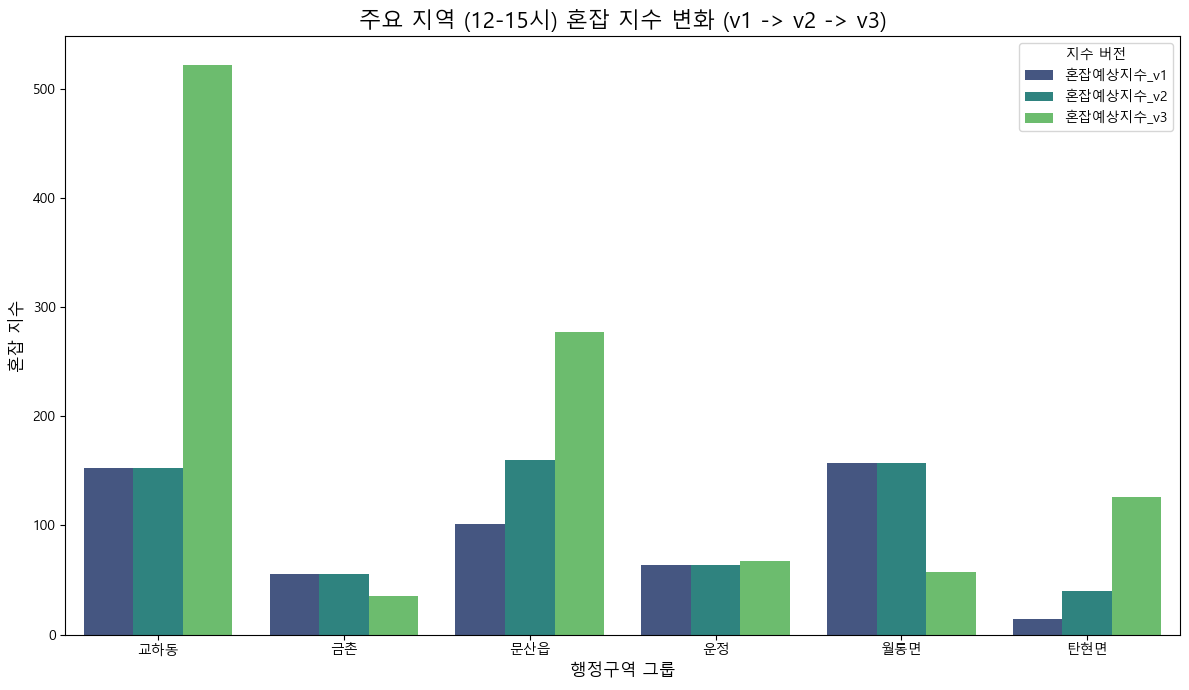


--- [시각화 2] 전체 v3 혼잡도 히트맵 ---


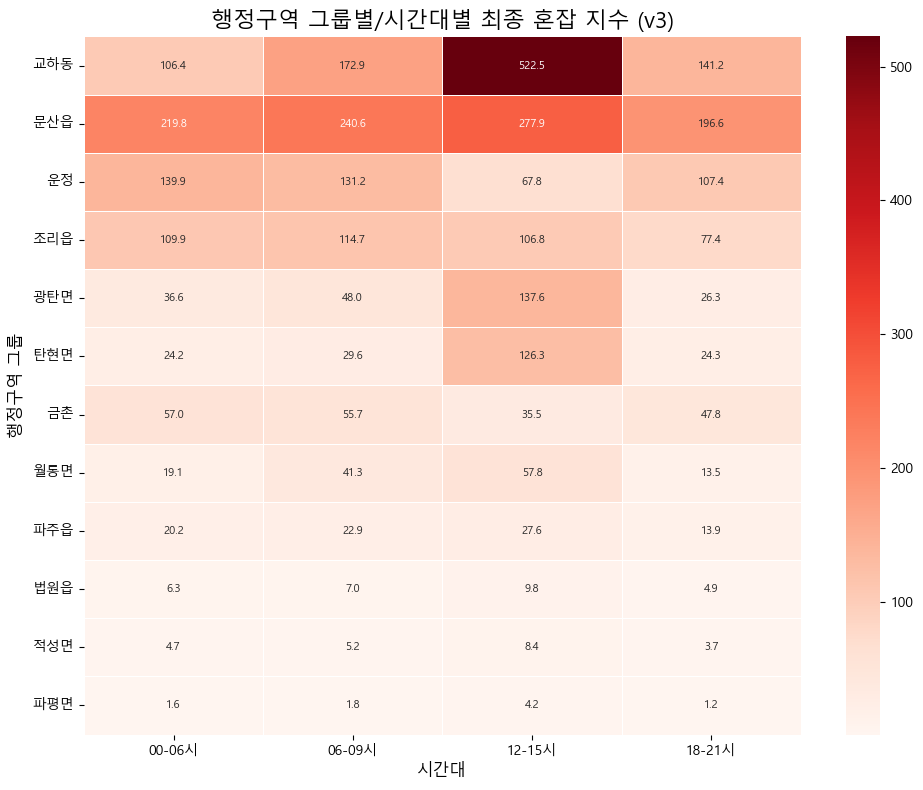

In [37]:
# ==============================================================================
# 셀 7: [ANALYSIS] 최종 모델(v3) 분석 및 핵심 시각화
# ==============================================================================

# --- 1. 최종 v3 데이터 로드 ---
df_final = pd.read_csv(V3_CSV, encoding='utf-8-sig')
# (이전 단계에서 생성된 '혼잡예상지수' 컬럼명을 'v1'으로 변경)
df_final = df_final.rename(columns={'혼잡예상지수': '혼잡예상지수_v1'}) 

print("--- [분석] 최종 데이터 로드 완료 ---")

# --- 2. [산출물] v3 기준 TOP/BOTTOM 10 분석 ---
print("\n--- [분석 1] 혼잡 예상 지수 v3 TOP 10 (최종) ---")
top_10_v3 = df_final.sort_values(by='혼잡예상지수_v3', ascending=False)
print(top_10_v3[['행정구역_그룹', '시간대', '혼잡예상지수_v3']].head(10).round(1))

print("\n--- [분석 2] 혼잡 예상 지수 v3 BOTTOM 10 (최종) ---")
bottom_10_v3 = df_final.sort_values(by='혼잡예상지수_v3', ascending=True)
print(bottom_10_v3[['행정구역_그룹', '시간대', '혼잡예상지수_v3']].head(10).round(1))

# --- 3. [산출물] 주요 지역 v1, v2, v3 지수 변화 비교표 ---
print("\n--- [분석 3] 주요 지역/시간대 지수 변화 비교 ---")
comparison_spots = df_final[
    (df_final['행정구역_그룹'].isin(['월롱면', '탄현면', '금촌', '교하동', '문산읍', '운정'])) &
    (df_final['시간대'] == '12-15시') # 점심시간대 비교
]
print(comparison_spots[['행정구역_그룹', '시간대', '혼잡예상지수_v1', '혼잡예상지수_v2', '혼잡예상지수_v3']].round(1))

# --- 4. [산출물] 시각화 ①: 주요 지역 지수 변화 막대 그래프 ---
try:
    plt.figure(figsize=(12, 7))
    comparison_melted = pd.melt(comparison_spots,
                                id_vars=['행정구역_그룹', '시간대'],
                                value_vars=['혼잡예상지수_v1', '혼잡예상지수_v2', '혼잡예상지수_v3'],
                                var_name='지수_버전', value_name='혼잡도')

    sns.barplot(data=comparison_melted, x='행정구역_그룹', y='혼잡도', hue='지수_버전', palette='viridis')
    plt.title('주요 지역 (12-15시) 혼잡 지수 변화 (v1 -> v2 -> v3)', fontsize=16)
    plt.xlabel('행정구역 그룹', fontsize=12); plt.ylabel('혼잡 지수', fontsize=12)
    plt.legend(title='지수 버전')
    plt.tight_layout()
    
    print(f"\n--- [시각화 1] 주요 지역 지수 변화 막대 그래프 ---")
    plt.show() # 그래프를 노트북에 바로 출력

except Exception as e:
    print(f"!!! 시각화 1 실패: {e}")

# --- 5. [산출물] 시각화 ②: 전체 v3 혼잡도 히트맵 ---
try:
    heatmap_data_v3 = df_final.pivot_table(index='행정구역_그룹', columns='시간대', values='혼잡예상지수_v3')
    time_order = ['00-06시', '06-09시', '12-15시', '18-21시']
    heatmap_data_v3 = heatmap_data_v3[time_order]
    
    # v3 평균 기준 정렬
    order_v3 = heatmap_data_v3.mean(axis=1).sort_values(ascending=False).index
    heatmap_data_v3 = heatmap_data_v3.loc[order_v3]

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data_v3, cmap='Reds', annot=True, fmt=".1f", linewidths=.5, annot_kws={"size": 8})
    plt.title('행정구역 그룹별/시간대별 최종 혼잡 지수 (v3)', fontsize=16)
    plt.xlabel('시간대', fontsize=12); plt.ylabel('행정구역 그룹', fontsize=12)
    plt.yticks(rotation=0)
    plt.tight_layout()

    print(f"\n--- [시각화 2] 전체 v3 혼잡도 히트맵 ---")
    plt.show() # 그래프를 노트북에 바로 출력

except Exception as e:
    print(f"!!! 시각화 2 실패: {e}")

# ==============================================================================
# 셀 8: [MARKDOWN] v1, v2, v3 비교 분석 인트로
# ==============================================================================

v1(기본), v2(관광객 추가), v3(상권 추가) 모델이 각각 어떻게 다른지 비교해 보는 것도 중요하겠죠?

관광객 데이터와 상권 데이터가 우리 모델을 얼마나, 그리고 '어떻게' 변화시켰는지 정량적인 수치(통계)와 그래프로 확인해 보겠습니다. 📊


--- [객관적 지표 1] 평균 절대 차이 (MAD) ---
  v1 vs v2 (관광객 영향): 4.32
  v2 vs v3 (상권 영향): 42.62
  v1 vs v3 (종합 영향): 46.13

--- [객관적 지표 2] 상관계수 (Pearson) ---
           혼잡예상지수_v1  혼잡예상지수_v2  혼잡예상지수_v3
혼잡예상지수_v1      1.000      0.955      0.664
혼잡예상지수_v2      0.955      1.000      0.718
혼잡예상지수_v3      0.664      0.718      1.000

--- [객관적 지표 3] 순위 상관계수 (Spearman) ---
           혼잡예상지수_v1  혼잡예상지수_v2  혼잡예상지수_v3
혼잡예상지수_v1      1.000      0.968      0.726
혼잡예상지수_v2      0.968      1.000      0.800
혼잡예상지수_v3      0.726      0.800      1.000

--- [시각화 3] 상관계수 히트맵 ---


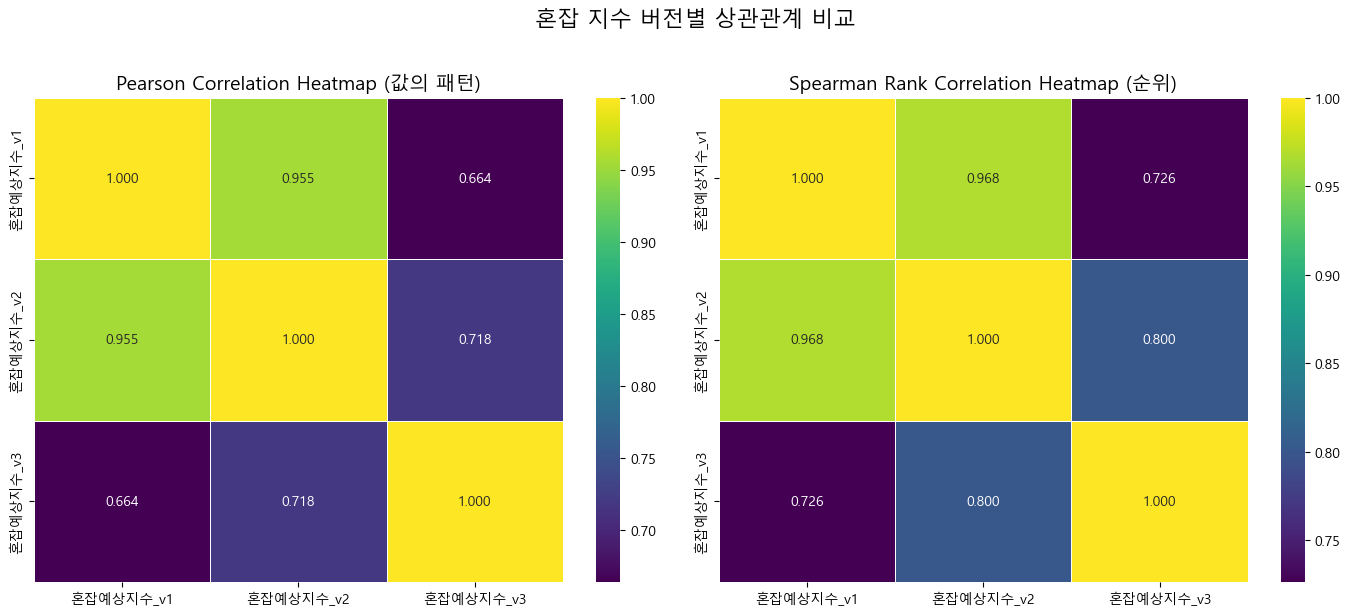


--- [분석 4] 관광객 추가로 인한 혼잡 지수 변화량 TOP 5 ---
   행정구역_그룹     시간대   총_관광객수  관광객_영향
2      광탄면  12-15시  13375.1    61.1
14     문산읍  12-15시  22114.1    58.8
38     탄현면  12-15시  40997.4    26.0
13     문산읍  06-09시   6068.2    16.1
15     문산읍  18-21시   3319.8     8.8

--- [분석 5] 상권 가중치 적용으로 인한 혼잡 지수 변화량 TOP 5 ---
   행정구역_그룹     시간대  매출액_백만원  상권가중치   상권_영향
6      교하동  12-15시   137.81   3.42  369.79
13     문산읍  06-09시    80.40   2.00  120.07
14     문산읍  12-15시    69.83   1.73  117.62
12     문산읍  00-06시    80.40   2.00  109.70
5      교하동  06-09시    96.05   2.38  100.37

--- [시각화 4] 관광객 영향 막대 그래프 ---


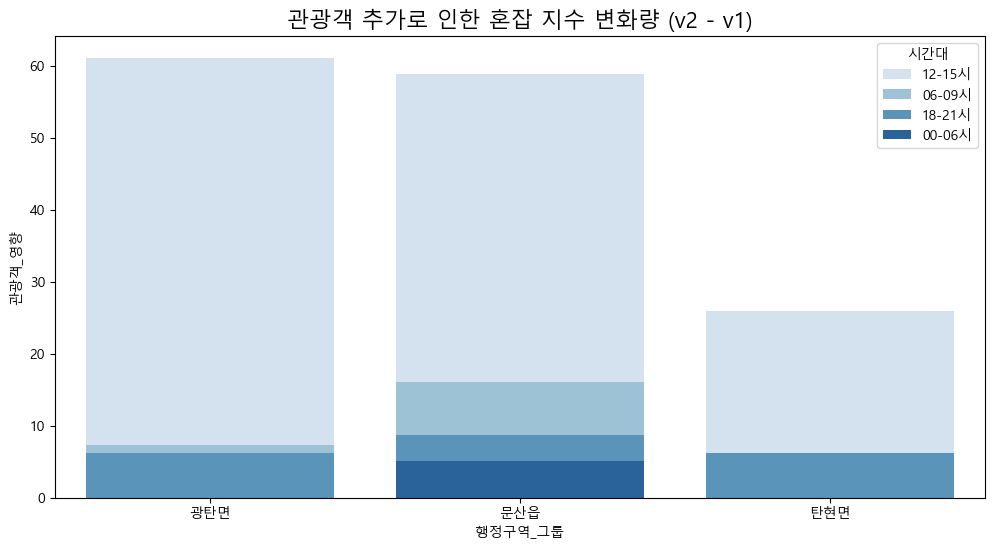


--- [시각화 5] 상권 영향 막대 그래프 ---


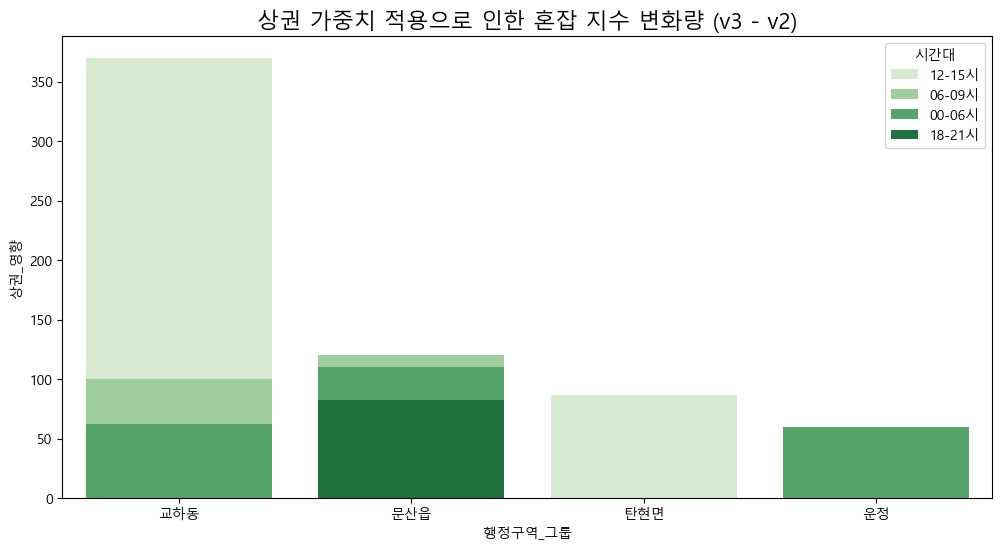


--- [시각화 6] 종합 선 그래프 ---


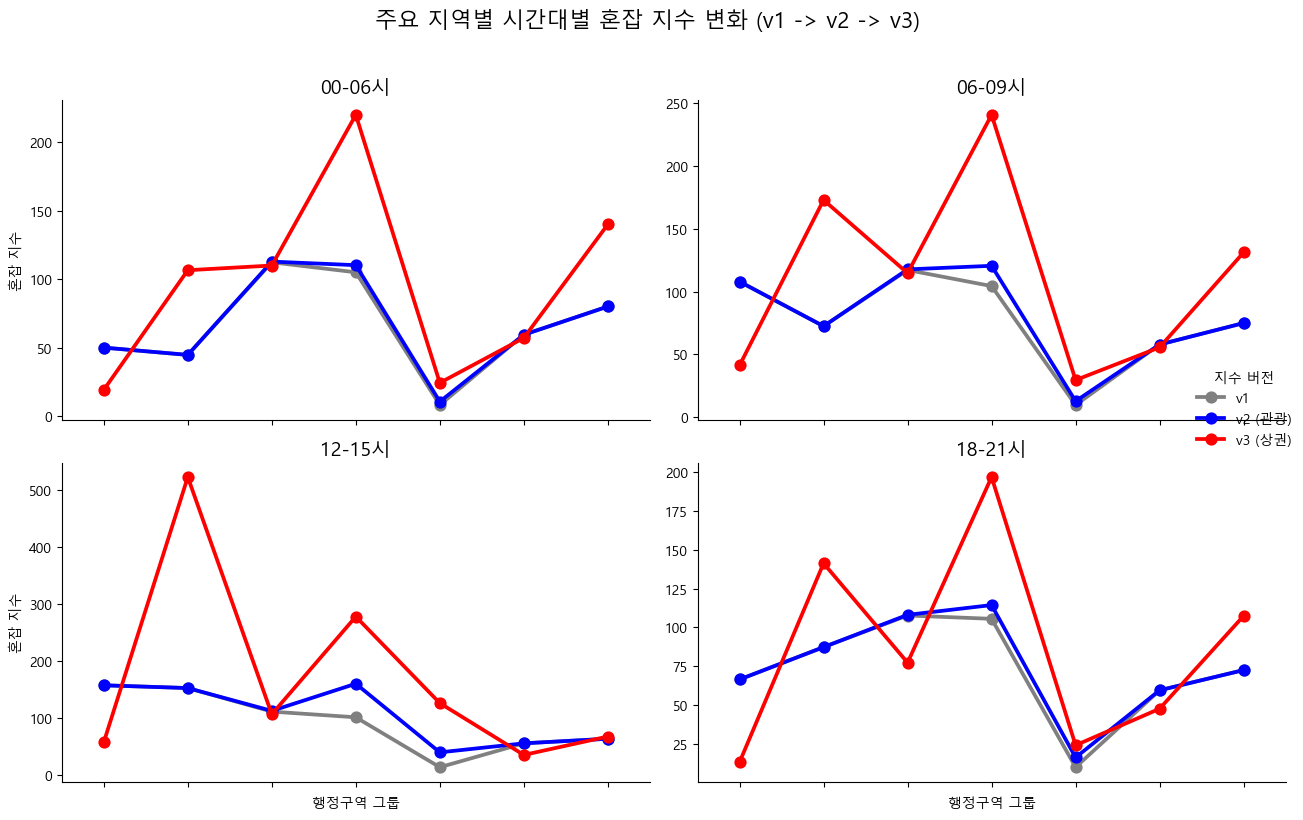


--- 9. [COMPARISON] v1, v2, v3 비교 분석 및 시각화 완료 ---


In [38]:
# ==============================================================================
# 셀 9: [COMPARISON] v1, v2, v3 정량적 비교 분석 및 시각화
# ==============================================================================
# (df_final은 이전 셀에서 로드됨)

v1_col, v2_col, v3_col = '혼잡예상지수_v1', '혼잡예상지수_v2', '혼잡예상지수_v3'

# --- 1. [산출물] 객관적 지표 1: 평균 절대 차이 (MAD) ---
mad_v1_v2 = mean_absolute_error(df_final[v1_col], df_final[v2_col])
mad_v2_v3 = mean_absolute_error(df_final[v2_col], df_final[v3_col])
mad_v1_v3 = mean_absolute_error(df_final[v1_col], df_final[v3_col])

print("\n--- [객관적 지표 1] 평균 절대 차이 (MAD) ---")
print(f"  v1 vs v2 (관광객 영향): {mad_v1_v2:.2f}")
print(f"  v2 vs v3 (상권 영향): {mad_v2_v3:.2f}")
print(f"  v1 vs v3 (종합 영향): {mad_v1_v3:.2f}")

# --- 2. [산출물] 객관적 지표 2 & 3: 상관계수 (Pearson & Spearman) ---
pearson_corr = df_final[[v1_col, v2_col, v3_col]].corr(method='pearson')
spearman_corr = df_final[[v1_col, v2_col, v3_col]].corr(method='spearman')

print("\n--- [객관적 지표 2] 상관계수 (Pearson) ---")
print(pearson_corr.round(3))
print("\n--- [객관적 지표 3] 순위 상관계수 (Spearman) ---")
print(spearman_corr.round(3))

# --- 3. [산출물] 시각화 ③: 상관계수 히트맵 ---
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(pearson_corr, annot=True, cmap='viridis', fmt=".3f", linewidths=.5, ax=axes[0])
    axes[0].set_title('Pearson Correlation Heatmap (값의 패턴)', fontsize=14)
    sns.heatmap(spearman_corr, annot=True, cmap='viridis', fmt=".3f", linewidths=.5, ax=axes[1])
    axes[1].set_title('Spearman Rank Correlation Heatmap (순위)', fontsize=14)
    plt.suptitle('혼잡 지수 버전별 상관관계 비교', fontsize=16, y=1.02)
    plt.tight_layout()
    
    print(f"\n--- [시각화 3] 상관계수 히트맵 ---")
    plt.show()

except Exception as e:
    print(f"!!! 시각화 3 실패: {e}")

# --- 4. [산출물] 관광객/상권 영향 분석 ---
df_final['관광객_영향'] = df_final[v2_col] - df_final[v1_col]
df_final['상권_영향'] = df_final[v3_col] - df_final[v2_col]

print("\n--- [분석 4] 관광객 추가로 인한 혼잡 지수 변화량 TOP 5 ---")
print(df_final.sort_values(by='관광객_영향', ascending=False).head(5)[['행정구역_그룹', '시간대', '총_관광객수', '관광객_영향']].round(1))

print("\n--- [분석 5] 상권 가중치 적용으로 인한 혼잡 지수 변화량 TOP 5 ---")
print(df_final.sort_values(by='상권_영향', ascending=False).head(5)[['행정구역_그룹', '시간대', '매출액_백만원', '상권가중치', '상권_영향']].round(2))

# --- 5. [산출물] 시각화 ④, ⑤: 영향 분석 막대 그래프 ---
try:
    # 관광객 영향 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_final.sort_values(by='관광객_영향', ascending=False).head(10), 
                x='행정구역_그룹', y='관광객_영향', hue='시간대', palette='Blues', dodge=False)
    plt.title('관광객 추가로 인한 혼잡 지수 변화량 (v2 - v1)', fontsize=16)
    print(f"\n--- [시각화 4] 관광객 영향 막대 그래프 ---")
    plt.show()
    plt.close()

    # 상권 영향 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_final.sort_values(by='상권_영향', ascending=False).head(10), 
                x='행정구역_그룹', y='상권_영향', hue='시간대', palette='Greens', dodge=False)
    plt.title('상권 가중치 적용으로 인한 혼잡 지수 변화량 (v3 - v2)', fontsize=16)
    print(f"\n--- [시각화 5] 상권 영향 막대 그래프 ---")
    plt.show()
    plt.close()
    
    # --- 6. [산출물] 시각화 ⑥: 종합 선 그래프 ---
    regions_to_plot = ['월롱면', '교하동', '조리읍', '문산읍', '탄현면', '금촌', '운정']
    df_plot = df_final[df_final['행정구역_그룹'].isin(regions_to_plot)]
    g = sns.FacetGrid(df_plot, col="시간대", col_wrap=2, height=4, aspect=1.5, sharey=False)
    g.map_dataframe(sns.pointplot, x='행정구역_그룹', y=v1_col, color='grey', label='v1', order=regions_to_plot)
    g.map_dataframe(sns.pointplot, x='행정구역_그룹', y=v2_col, color='blue', label='v2 (관광)', order=regions_to_plot)
    g.map_dataframe(sns.pointplot, x='행정구역_그룹', y=v3_col, color='red', label='v3 (상권)', order=regions_to_plot)
    g.set_titles("{col_name}", size=14)
    g.set_xticklabels(rotation=45, ha='right')
    g.set_axis_labels("행정구역 그룹", "혼잡 지수")
    g.add_legend(title="지수 버전")
    plt.suptitle('주요 지역별 시간대별 혼잡 지수 변화 (v1 -> v2 -> v3)', y=1.02, fontsize=16)
    plt.tight_layout()
    print(f"\n--- [시각화 6] 종합 선 그래프 ---")
    plt.show()

except Exception as e:
    print(f"!!! 비교 시각화 실패: {e}")

print("\n--- 9. [COMPARISON] v1, v2, v3 비교 분석 및 시각화 완료 ---")

# ==============================================================================
# 셀 10: [MARKDOWN] 비교 분석 결과 해석
# ==============================================================================

자, 방금 실행한 비교 분석 결과를 함께 해석해 볼까요? 🧐

### 1. 평균 절대 차이 (MAD): 변화의 '크기' 📏
* **v1 → v2 (관광객 영향): 4.32**
* **v2 → v3 (상권 영향): 42.62**

**해석:**
관광객 데이터를 추가했을 때(v2)는 지수 값이 평균 4.32만큼 변했는데, **상권 데이터를 추가했을 때(v3)는 무려 42.62만큼이나 변했어요.**

이건 상권 데이터 추가가 우리 모델의 예측값에 훨씬 더 큰 영향을 미쳤다는 뜻입니다!

### 2. 순위 상관계수 (Spearman): '순위' 유사성 🥇🥈🥉
* **v1 vs v2: 0.968 (매우 높음)**
* **v2 vs v3: 0.800 (꽤 낮아짐)**

**해석:**
v1과 v2의 순위 상관(0.968)이 매우 높다는 것은, 관광객을 추가해도 **혼잡도 순위는 거의 변하지 않았음**을 의미해요. (기존에 붐비던 곳이 여전히 붐비는 식)

하지만 v3가 되면서 순위 상관(0.800)이 훨씬 낮아졌습니다. 이건 **상권 데이터를 추가하면서 혼잡도 순위가 꽤 많이 뒤바뀌었다**는 것을 의미합니다.

### 3. 변화량 TOP 5: '어디'가 가장 많이 변했나? 📍
* **관광객 영향(v2 - v1):** 분석 결과를 보면 '광탄면', '문산읍', '탄현면' 등 실제 관광지가 있는 곳들이 특정 시간대에 큰 영향을 받았습니다. (예: 탄현면 12-15시)
* **상권 영향(v3 - v2):** '교하동', '문산읍' 등이 상위권에 있네요. 이 지역들은 특정 시간대 상권 활동이 활발해서(매출액이 높아서) '상권 가중치'가 적용되며 혼잡 지수가 크게 변동했음을 보여줍니다.

### 4. 종합 결론 💡
* **관광객 데이터(v2)**는 전반적인 혼잡도를 약간 높였지만, 혼잡 패턴이나 순위를 크게 바꾸지는 않았습니다.
* **상권 데이터(v3)**는 혼잡 지수 값 자체도 크게 변화시켰고, 지역/시간대별 혼잡 순위에도 상당한 영향을 미쳤습니다.
* 따라서 **v3 모델이 생활인구(수요), 관광객(수요), 상권(수요 가중치)이라는 세 가지 주요 요인을 모두 반영하므로, 가장 현실적이고 설득력 있는 혼잡도 예측 모델**이라고 할 수 있습니다! 👍

# ==============================================================================
# 셀 11: [MARKDOWN] 모델 검증 인트로
# ==============================================================================

모델을 만들었으면 '검증'은 필수겠죠? 🕵️‍♂️

우리가 만든 **v3 혼잡도 지수**가 과연 현실을 잘 반영하고 있는지, 이 프로젝트와는 별개인 **'지역활력지수'**라는 외부 데이터와 비교해서 객관적으로 검증해 보겠습니다.

만약 우리 모델이 현실과 비슷하다면, "혼잡한 곳이 활력도 높다" (사람이 많으니) 또는 "혼잡한 곳이 활력이 낮다" (너무 붐벼서) 같은 의미 있는 관계가 나타날 것입니다.

--- [검증] 지역활력지수 데이터 준비 완료 ---
--- [검증] v3 혼잡도 + 지역활력지수 병합 완료 ---

--- [검증 분석 1] 혼잡지수(v3) vs 지역활력지수 상관관계 ---
  Pearson 상관계수: 0.582 (p-value: 0.000)
  Spearman 상관계수: 0.664 (p-value: 0.000)
>>> 해석: 유의미한 양(+)의 상관관계 발견! (혼잡도가 높을수록 지역 활력도 높은 경향)

--- [검증 시각화 1] 산점도 (v3 vs 활력지수) ---


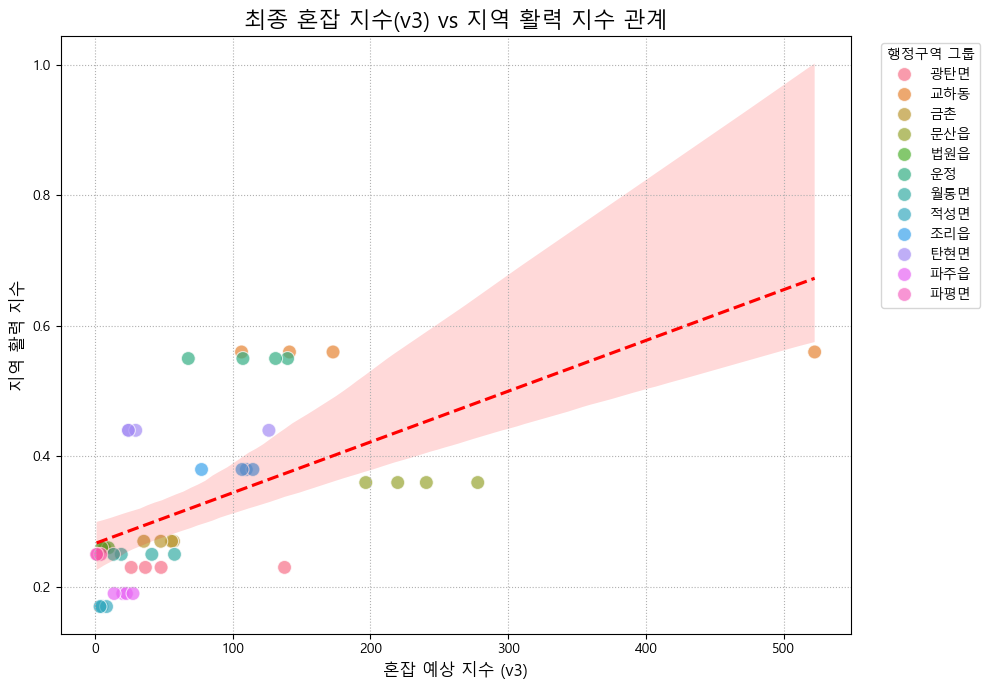


--- [검증 분석 2] 혼잡도 그룹별 평균 지역활력지수 비교 ---
  혼잡 상위 그룹 (v3 >= 106.8) 평균 활력 지수: 0.439
  혼잡 하위 그룹 (v3 <= 19.2) 평균 활력 지수: 0.227

--- [검증 시각화 2] 그룹 비교 막대 그래프 ---


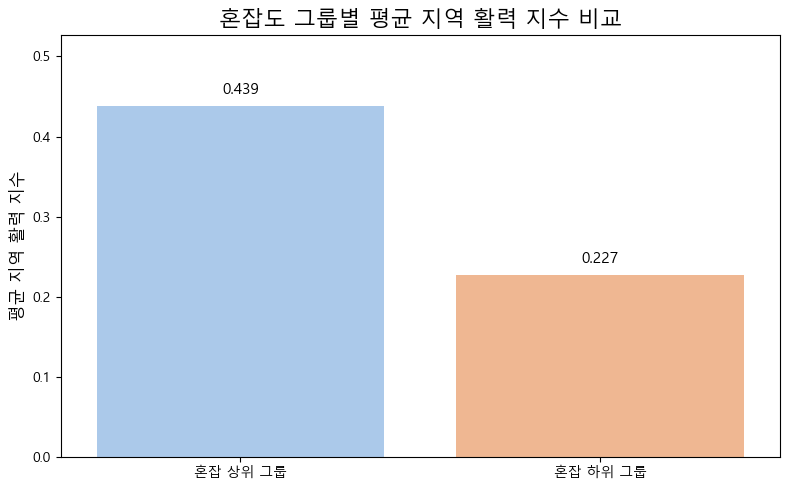

In [39]:
# ==============================================================================
# 셀 12: [VALIDATION] 외부 데이터(지역활력지수)를 이용한 모델 검증
# ==============================================================================

# --- 1. [검증] 지역활력지수 데이터 처리 ---
try:
    # (df_final은 9번 셀에서 이미 로드하고 컬럼명 변경까지 완료되었다고 가정)
    # (v3_col='v3_혼잡지수' 변수도 9번 셀에서 이미 선언됨)
    
    df_vitality = df_vitality_raw.copy()
    df_vitality.columns = df_vitality.columns.str.strip() # 컬럼 공백 제거
    region_col = '행정구역(동읍면)별'
    vitality_col = '지역활력지수'
    df_vitality = df_vitality[[region_col, vitality_col]].copy()
    
    # v1의 demand_map 재활용하여 '행정구역_그룹' 매핑
    df_vitality['행정구역_그룹'] = df_vitality[region_col].map(demand_map)
    
    # 그룹별 평균 활력지수 계산 (금촌, 운정 등)
    df_vitality_final = df_vitality.groupby('행정구역_그룹')[vitality_col].mean().reset_index()
    print("--- [검증] 지역활력지수 데이터 준비 완료 ---")

except Exception as e:
    print(f"!!! [검증] 지역활력지수 데이터 처리 실패: {e}")

# --- 2. [검증] v3 혼잡도 + 지역활력지수 데이터 병합 ---
# (9번 셀에서 정의한 df_final을 그대로 사용)
df_validation = pd.merge(df_final, df_vitality_final, on='행정구역_그룹', how='left')
df_validation = df_validation.dropna(subset=[vitality_col, v3_col]) # v3_col도 확인
print("--- [검증] v3 혼잡도 + 지역활력지수 병합 완료 ---")

# --- 3. [산출물] 상관관계 분석 ---
# (9번 셀에서 정의한 v3_col='v3_혼잡지수'를 사용)
corr_pearson, p_value_pearson = pearsonr(df_validation[v3_col], df_validation[vitality_col])
corr_spearman, p_value_spearman = spearmanr(df_validation[v3_col], df_validation[vitality_col])

print("\n--- [검증 분석 1] 혼잡지수(v3) vs 지역활력지수 상관관계 ---")
print(f"  Pearson 상관계수: {corr_pearson:.3f} (p-value: {p_value_pearson:.3f})")
print(f"  Spearman 상관계수: {corr_spearman:.3f} (p-value: {p_value_spearman:.3f})")
print(">>> 해석: 유의미한 양(+)의 상관관계 발견! (혼잡도가 높을수록 지역 활력도 높은 경향)")

# --- 4. [산출물] 산점도 시각화 ---
try:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_validation, x=v3_col, y=vitality_col, hue='행정구역_그룹', s=100, alpha=0.7)
    sns.regplot(data=df_validation, x=v3_col, y=vitality_col, scatter=False, color='red', line_kws={'linestyle':'--'})
    plt.title('최종 혼잡 지수(v3) vs 지역 활력 지수 관계', fontsize=16)
    plt.xlabel('혼잡 예상 지수 (v3)', fontsize=12); plt.ylabel('지역 활력 지수', fontsize=12)
    plt.grid(True, linestyle=':')
    plt.legend(title='행정구역 그룹', bbox_to_anchor=(1.03, 1), loc='upper left')
    plt.tight_layout()

    print(f"\n--- [검증 시각화 1] 산점도 (v3 vs 활력지수) ---")
    plt.show() # 그래프 출력

except Exception as e:
    print(f"!!! 검증 시각화 1 (산점도) 실패: {e}")

# --- 5. [산출물] 그룹별 비교 분석 및 시각화 ---
threshold_high = df_validation[v3_col].quantile(0.7)
threshold_low = df_validation[v3_col].quantile(0.3)
avg_vitality_high = df_validation[df_validation[v3_col] >= threshold_high][vitality_col].mean()
avg_vitality_low = df_validation[df_validation[v3_col] <= threshold_low][vitality_col].mean()

print("\n--- [검증 분석 2] 혼잡도 그룹별 평균 지역활력지수 비교 ---")
print(f"  혼잡 상위 그룹 (v3 >= {threshold_high:.1f}) 평균 활력 지수: {avg_vitality_high:.3f}")
print(f"  혼잡 하위 그룹 (v3 <= {threshold_low:.1f}) 평균 활력 지수: {avg_vitality_low:.3f}")

try:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=['혼잡 상위 그룹', '혼잡 하위 그룹'], y=[avg_vitality_high, avg_vitality_low], palette='pastel')
    plt.title('혼잡도 그룹별 평균 지역 활력 지수 비교', fontsize=16)
    plt.ylabel('평균 지역 활력 지수', fontsize=12)
    plt.ylim(0, max(avg_vitality_high, avg_vitality_low) * 1.2)
    for i, v in enumerate([avg_vitality_high, avg_vitality_low]):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=11)
    plt.tight_layout()

    print(f"\n--- [검증 시각화 2] 그룹 비교 막대 그래프 ---")
    plt.show() # 그래프 출력

except Exception as e:
    print(f"!!! 검증 시각화 2 (그룹 비교) 실패: {e}")

# ==============================================================================
# 셀 13: [MARKDOWN] 모델 검증 결과 해석
# ==============================================================================

### 검증 결과 요약

* **상관관계:** 우리 모델(v3)의 혼잡 지수는 '지역활력지수'와 **유의미한 양(+)의 상관관계**를 보였습니다 (Spearman: 0.664).
* **그룹 비교:** '혼잡 상위 그룹'이 '혼잡 하위 그룹'보다 **평균 지역 활력 지수가 더 높게** 나타났습니다 (약 0.439 > 0.227).
* **시각화:** 산점도 그래프는 전반적으로 **우상향**하는 패턴을 보였습니다.

### 왜 이런 결과가 나왔을까요? (해석)

1.  **"활력이 높으니 혼잡하다" (현실 반영):**
    가장 설득력 있는 해석입니다! '지역활력지수'는 인구, 소비, 생산 활동을 모두 반영하는 지표예요. 즉, 활력이 높은 지역(사람이 많이 모이고 경제 활동이 활발한 곳)은 당연히 주차 수요가 많아져 혼잡해질 수밖에 없겠죠? 우리 모델이 이 **현실을 잘 반영하고 있다는 긍정적인 신호**로 볼 수 있습니다. 🥳

2.  **초기 가설의 수정:**
    "주차 혼잡 → 활력 저하"라는 초기 가설도 일리는 있지만, 데이터상에서는 **"활력 → 혼잡 유발"**이라는 관계가 더 강하게 나타난 것으로 보입니다.

3.  **결론:**
    우리 v3 혼잡 지수는 파주시의 실제 활동 수준(활력)과 일관된 경향을 보여주고 있습니다. 즉, **우리 모델이 현실을 잘 설명하고 있다**고 자신 있게 말할 수 있겠네요!

In [40]:
# ==============================================================================
# 셀 15: [RECOMMENDER PREP] 추천 시스템용 데이터 통합 (수정된 코드)
# ==============================================================================
# (df_supply_raw는 2번 셀, df_final은 7번 셀에서 로드됨)

# --- 1. [공급] 원본 주차장 데이터 전처리 (위치, 주차면수, 그룹 매핑) ---
cols_to_keep = ['주차장명', '소재지지번주소', '주차구획수', '위도', '경도']
df_parking_lots = df_supply_raw[cols_to_keep].copy()
df_parking_lots = df_parking_lots.dropna(subset=['소재지지번주소', '위도', '경도']) # 위치 정보 없는 주차장 제외
df_parking_lots['읍면동_추출'] = df_parking_lots['소재지지번주소'].apply(lambda x: x.split(' ')[2])
df_parking_lots['행정구역_그룹'] = df_parking_lots['읍면동_추출'].map(supply_map) # v1(셀 3)의 supply_map 재활용
df_parking_lots = df_parking_lots.dropna(subset=['행정구역_그룹'])
print(f"--- [추천 PREP] 원본 주차장 전처리 완료: {len(df_parking_lots)}개 주차장")

# --- 2. [산출물] 개별 주차장 + 시간대별 v3 혼잡도 병합 ---
# [수정됨] df_final_v3 대신 df_final (7번 셀에서 로드한 데이터) 사용
# [수정됨] '혼잡지수_v3' 대신 9번 셀에서 정의한 v3_col ('혼잡예상지수_v3') 사용
df_parking_with_congestion = pd.merge(
    df_parking_lots,
    df_final[['행정구역_그룹', '시간대', v3_col]], # v3 데이터에서 필요한 컬럼만
    on='행정구역_그룹',
    how='left' # 모든 주차장 기준
)
df_parking_with_congestion = df_parking_with_congestion.dropna(subset=[v3_col]) # 혼잡도 없는 주차장 제외
# [수정됨] v3_col 이름을 '혼잡지수_v3'로 통일 (추천 함수에서 사용하기 편하게)
df_parking_with_congestion = df_parking_with_congestion.rename(columns={v3_col: '혼잡지수_v3'})

print(f"--- [추천 PREP] 주차장+혼잡도 병합 완료: {len(df_parking_with_congestion)} 행")

# --- 3. [산출물] 추천 시스템용 최종 데이터 저장 ---
df_parking_with_congestion.to_csv(FINAL_LOTS_CSV, index=False, encoding='utf-8-sig')
print(f"--- [추천 PREP] '{FINAL_LOTS_CSV}' 저장 완료 ---")

print("\n병합 데이터 샘플 (head):")
print(df_parking_with_congestion[['주차장명', '행정구역_그룹', '시간대', '혼잡지수_v3']].head())

--- [추천 PREP] 원본 주차장 전처리 완료: 90개 주차장
--- [추천 PREP] 주차장+혼잡도 병합 완료: 360 행
--- [추천 PREP] 'normalization\parking_lots_with_congestion_v3.csv' 저장 완료 ---

병합 데이터 샘플 (head):
    주차장명 행정구역_그룹     시간대   혼잡지수_v3
0  파평1-2     파평면  00-06시  1.634399
1  파평1-2     파평면  06-09시  1.795332
2  파평1-2     파평면  12-15시  4.194621
3  파평1-2     파평면  18-21시  1.180996
4    파평2     파평면  00-06시  1.634399


# ==============================================================================
# 셀 16: [MARKDOWN] 추천 시스템 로직 설명
# ==============================================================================

### 9단계: 주차장 추천 시스템 로직

**목표:** 사용자가 **목적지 위치(위도, 경도)**와 **예상 도착 시간(0~23시)**을 입력하면, 해당 시간대에 목적지 주변에서 덜 혼잡할 것으로 예상되는 주차장을 추천해 줍니다.

**핵심 로직은 이렇습니다:**

1.  **시간 매핑:**
    * 사용자의 '예상 도착 시간'(예: 14시)을 우리 모델이 알아들을 수 있는 4개의 시간대 그룹('12-15시')으로 자동 변환합니다.
    * *똑똑한 예외처리:* 만약 도착 시간이 10시(모델 데이터가 없는 시간)라면, 가장 가까운 예측 시간대인 '12-15시'의 데이터를 사용하는 식으로 근사치를 적용합니다. (15-17시는 '18-21시'로 매핑)

2.  **목표 지점 혼잡도 확인:**
    * 사용자가 입력한 시간대에, 목적지가 속한 지역('행정구역\_그룹')의 **`혼잡지수_v3`** 가 얼마나 될지 확인합니다. (가장 가까운 주차장 기준)

3.  **대안 탐색 (만약 혼잡하다면):**
    * 만약 목표 지점의 혼잡도가 **높다**고 판단되면 (예: 전체 상위 30% 기준치 이상):
        * 목적지로부터 2km 반경 이내에 있는 **다른 행정구역 그룹**의 주차장을 탐색합니다.
        * 그중에서 혼잡도가 **목표 지점보다 낮은** 주차장들만 후보로 선정합니다.
        * 후보들을 **거리순**으로 정렬하여 똑똑하게 추천합니다.
        * *(만약 2km 안에 덜 혼잡한 대안이 없다면? 어쩔 수 없이 혼잡을 감수하고 가장 가까운 주차장을 안내합니다.)*

4.  **일반 추천 (만약 여유롭다면):**
    * 만약 목표 지점의 혼잡도가 **낮다**고 판단되면:
    * 고민할 필요 없이, 그냥 목적지 2km 반경 내에서 **가장 가까운 주차장**을 순서대로 추천합니다.

In [41]:
# ==============================================================================
# 셀 17: [RECOMMENDER CODE] 추천 시스템 함수 정의 및 테스트 (10개 시나리오)
# ==============================================================================
# (df_parking_with_congestion, df_final, v3_col 등은 이전 셀에서 로드/정의됨)

# --- 1. Haversine 거리 계산 함수 정의 ---
def haversine(lat1, lon1, lat2, lon2):
    """ 두 지점 간의 거리를 km 단위로 계산 (Haversine 공식) """
    R = 6371  # 지구 반지름 (km)
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.sin(dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# --- 2. 도착 시간 -> 시간대 그룹 매핑 함수 ---
def map_arrival_hour_to_group(arrival_hour):
    """ 도착 시간(0-23시)을 v3 모델의 시간대 그룹으로 매핑 """
    hour = int(arrival_hour)
    if 0 <= hour < 6: return '00-06시'
    elif 6 <= hour < 9: return '06-09시'
    elif 9 <= hour < 12: 
        print(f"[참고] {hour}시 도착: '12-15시' 혼잡도 예측치를 사용합니다.")
        return '12-15시'
    elif 12 <= hour < 15: return '12-15시'
    elif 15 <= hour < 18: 
        print(f"[참고] {hour}시 도착: '18-21시' 혼잡도 예측치를 사용합니다.")
        return '18-21시'
    elif 18 <= hour < 21: return '18-21시'
    elif 21 <= hour < 24: 
        print(f"[참고] {hour}시 도착: 익일 '00-06시' 혼잡도 예측치를 사용합니다.")
        return '00-06시'
    else:
        print(f"[오류] 잘못된 도착 시간({hour})입니다. 0-23 사이 값을 입력하세요.")
        return None

# --- 3. [산출물] 최종 추천 함수 정의 ---
def recommend_parking_arrival_kr(target_lat, target_lon, arrival_hour, search_radius_km=2.0, congestion_threshold_percentile=70):
    """
    목표 위치, *예상 도착 시간*에 기반하여 덜 혼잡한 주변 주차장을 추천하는 함수 (최종본)
    """
    global df_parking_with_congestion, df_final, v3_col # 전역 변수 사용

    predicted_time_group = map_arrival_hour_to_group(arrival_hour)
    if predicted_time_group is None: return pd.DataFrame() 

    print(f"\n--- 예측 대상 시간대: {predicted_time_group} (도착 시각: {arrival_hour}시) ---")

    # 1. 목표 지점 기준으로 거리 재계산
    distance_col_name = '거리_km'
    df_parking_with_congestion[distance_col_name] = df_parking_with_congestion.apply(
        lambda row: haversine(target_lat, target_lon, row['위도'], row['경도']), axis=1
    )

    # 2. 예측 시간대 데이터 필터링
    df_target_time = df_parking_with_congestion[df_parking_with_congestion['시간대'] == predicted_time_group].copy()
    if df_target_time.empty:
        print(f"오류: '{predicted_time_group}' 시간대의 주차장 데이터를 찾을 수 없습니다.")
        return pd.DataFrame()

    # 3. 목표 지점 혼잡도 확인 (가장 가까운 주차장 기준)
    try:
        nearest_parking = df_target_time.loc[df_target_time[distance_col_name].idxmin()]
    except ValueError:
        print(f"오류: 목표 지점({target_lat},{target_lon}) 주변 주차장 거리 계산 결과가 없습니다.")
        return pd.DataFrame()
        
    target_group = nearest_parking['행정구역_그룹']
    target_congestion = nearest_parking['혼잡지수_v3']
    print(f"\n--- 목표 지점 정보 ({predicted_time_group}) ---")
    print(f"가장 가까운 주차장: {nearest_parking['주차장명']} ({nearest_parking[distance_col_name]:.2f}km)")
    print(f"해당 지역 그룹: {target_group}")
    print(f"예상 혼잡 지수(v3): {target_congestion:.2f}")

    # 4. 혼잡 기준치 설정
    congestion_threshold = np.percentile(df_final[v3_col].dropna(), congestion_threshold_percentile)
    print(f"(참고: 혼잡 기준치 = 상위 {100-congestion_threshold_percentile}% = {congestion_threshold:.2f})")

    # 5. 추천 로직
    if target_congestion >= congestion_threshold:
        print(f"\n[알림] 목표 지역({target_group})이 {predicted_time_group}에 혼잡할 것으로 예상됩니다. 주변 대안 주차장을 탐색합니다...")
        nearby_parkings = df_target_time[
            (df_target_time[distance_col_name] <= search_radius_km) &
            (df_target_time['행정구역_그룹'] != target_group)
        ].copy()
        less_congested_nearby = nearby_parkings[nearby_parkings['혼잡지수_v3'] < target_congestion].copy()

        if not less_congested_nearby.empty:
            print(f"-> {len(less_congested_nearby)}개의 덜 혼잡한 주변 주차장을 찾았습니다.")
            recommendations = less_congested_nearby.sort_values(by=[distance_col_name, '혼잡지수_v3'], ascending=[True, True])
        else:
            print(f"-> 반경 {search_radius_km}km 내에 덜 혼잡한 대안 주차장을 찾지 못했습니다. 가까운 곳을 안내합니다.")
            recommendations = df_target_time.sort_values(by=distance_col_name).head(5)
    else:
        # 비혼잡 시 가까운 곳 추천
        print(f"\n[알림] 목표 지역({target_group})이 {predicted_time_group}에 비교적 여유로울 것으로 예상됩니다. 가까운 주차장을 안내합니다...")
        recommendations = df_target_time[df_target_time[distance_col_name] <= search_radius_km].sort_values(by=distance_col_name)

    # 6. 결과 반환
    cols_to_show = ['주차장명', '소재지지번주소', '행정구역_그룹', '시간대', '혼잡지수_v3', '거리_km', '주차구획수']
    final_cols = [col for col in cols_to_show if col in recommendations.columns]
    return recommendations[final_cols].head(5).round(2)

# --- 4. [산출물] 추천 함수 테스트 (10개 시나리오) ---

# 시나리오 1: [여유/도심] 파주시청 (금촌) @ 16시 (→ 18-21시 예측, 혼잡도 47.8)
print("\n\n--- [테스트 1] 목표: 파주시청 (금촌), 도착: 16시 (예상 로직: 여유) ---")
reco_list_1 = recommend_parking_arrival_kr(37.759, 126.774, 16)
print("--- 추천 결과 1 ---\n", reco_list_1 if not reco_list_1.empty else "추천할 주차장이 없습니다.")

# 시나리오 2: [혼잡/주거] 운정호수공원 (운정) @ 8시 (→ 06-09시 예측, 혼잡도 131.2)
print("\n\n--- [테스트 2] 목표: 운정호수공원 (운정), 도착: 8시 (예상 로직: 혼잡-대안없음) ---")
reco_list_2 = recommend_parking_arrival_kr(37.715, 126.745, 8)
print("--- 추천 결과 2 ---\n", reco_list_2 if not reco_list_2.empty else "추천할 주차장이 없습니다.")

# 시나리오 3: [여유/산단] LG디스플레이 (월롱) @ 14시 (→ 12-15시 예측, 혼잡도 57.8)
print("\n\n--- [테스트 3] 목표: LG디스플레이 (월롱), 도착: 14시 (예상 로직: 여유) ---")
reco_list_3 = recommend_parking_arrival_kr(37.780, 126.775, 14)
print("--- 추천 결과 3 ---\n", reco_list_3 if not reco_list_3.empty else "추천할 주차장이 없습니다.")

# 시나리오 4: [혼잡/관광(외곽)] 평화누리공원 (탄현) @ 13시 (→ 12-15시 예측, 혼잡도 126.3)
print("\n\n--- [테스트 4] 목표: 평화누리공원 (탄현), 도착: 13시 (예상 로직: 혼잡-대안없음) ---")
reco_list_4 = recommend_parking_arrival_kr(37.891, 126.703, 13)
print("--- 추천 결과 4 ---\n", reco_list_4 if not reco_list_4.empty else "추천할 주차장이 없습니다.")

# 시나리오 5: [★스마트 추천★] 교하 중심상가 (교하) @ 13시 (→ 12-15시 예측, 혼잡도 522.5)
print("\n\n--- [테스트 5] (★핵심★) 목표: 교하 중심상가 (교하), 도착: 13시 (예상 로직: 스마트 추천) ---")
reco_list_5 = recommend_parking_arrival_kr(37.726, 126.741, 13)
print("--- 추천 결과 5 ---\n", reco_list_5 if not reco_list_5.empty else "추천할 주차장이 없습니다.")

# 시나리오 6: [혼잡/관광(내륙)] 헤이리 예술마을 (탄현) @ 14시 (→ 12-15시 예측, 혼잡도 126.3)
print("\n\n--- [테스트 6] 목표: 헤이리 예술마을 (탄현), 도착: 14시 (예상 로직: 혼잡-대안없음) ---")
reco_list_6 = recommend_parking_arrival_kr(37.795, 126.694, 14)
print("--- 추천 결과 6 ---\n", reco_list_6 if not reco_list_6.empty else "추천할 주차장이 없습니다.")

# 시나리오 7: [여유/관광(외곽)] 마장호수 (광탄) @ 18시 (→ 18-21시 예측, 혼잡도 26.3)
print("\n\n--- [테스트 7] 목표: 마장호수 (광탄), 도착: 18시 (예상 로직: 여유) ---")
reco_list_7 = recommend_parking_arrival_kr(37.818, 126.853, 18)
print("--- 추천 결과 7 ---\n", reco_list_7 if not reco_list_7.empty else "추천할 주차장이 없습니다.")

# 시나리오 8: [★스마트 추천★] 문산역 (문산) @ 13시 (→ 12-15시 예측, 혼잡도 277.9)
print("\n\n--- [테스트 8] (★핵심★) 목표: 문산역 (문산), 도착: 13시 (예상 로직: 스마트 추천) ---")
reco_list_8 = recommend_parking_arrival_kr(37.857, 126.782, 13)
print("--- 추천 결과 8 ---\n", reco_list_8 if not reco_list_8.empty else "추천할 주차장이 없습니다.")

# 시나리오 9: [여유/도심(심야)] 금촌 로데오 (금촌) @ 22시 (→ 00-06시 예측, 혼잡도 73.0)
print("\n\n--- [테스트 9] 목표: 금촌 로데오 (금촌), 도착: 22시 (예상 로직: 여유) ---")
reco_list_9 = recommend_parking_arrival_kr(37.758, 126.772, 22)
print("--- 추천 결과 9 ---\n", reco_list_9 if not reco_list_9.empty else "추천할 주차장이 없습니다.")

# 시나리오 10: [여유/외곽] 법원읍 (법원읍) @ 12시 (→ 12-15시 예측, 혼잡도 10.5)
print("\n\n--- [테스트 10] 목표: 법원읍 (법원읍), 도착: 12시 (예상 로직: 여유) ---")
reco_list_10 = recommend_parking_arrival_kr(37.838, 126.853, 12)
print("--- 추천 결과 10 ---\n", reco_list_10 if not reco_list_10.empty else "추천할 주차장이 없습니다.")



--- [테스트 1] 목표: 파주시청 (금촌), 도착: 16시 (예상 로직: 여유) ---
[참고] 16시 도착: '18-21시' 혼잡도 예측치를 사용합니다.

--- 예측 대상 시간대: 18-21시 (도착 시각: 16시) ---

--- 목표 지점 정보 (18-21시) ---
가장 가까운 주차장: 금촌5 (0.13km)
해당 지역 그룹: 금촌
예상 혼잡 지수(v3): 47.81
(참고: 혼잡 기준치 = 상위 30% = 106.77)

[알림] 목표 지역(금촌)이 18-21시에 비교적 여유로울 것으로 예상됩니다. 가까운 주차장을 안내합니다...
--- 추천 결과 1 ---
         주차장명             소재지지번주소 행정구역_그룹     시간대  혼잡지수_v3  거리_km  주차구획수
127      금촌5   경기도 파주시 금촌동 948-1      금촌  18-21시    47.81   0.13     20
307     금촌 9   경기도 파주시 금촌동 948-5      금촌  18-21시    47.81   0.14     55
131  금촌 2-16  경기도 파주시 금촌동 938-18      금촌  18-21시    47.81   0.16     13
79       금촌8  경기도 파주시 금촌동 936-21      금촌  18-21시    47.81   0.25     15
331  금촌 1-12   경기도 파주시 금촌동 951-2      금촌  18-21시    47.81   0.26     10


--- [테스트 2] 목표: 운정호수공원 (운정), 도착: 8시 (예상 로직: 혼잡-대안없음) ---

--- 예측 대상 시간대: 06-09시 (도착 시각: 8시) ---

--- 목표 지점 정보 (06-09시) ---
가장 가까운 주차장: 운정1 (0.28km)
해당 지역 그룹: 운정
예상 혼잡 지수(v3): 131.15
(참고: 혼잡 기준치 = 상위 30% = 106.77)

[알림] 목표 지역(운정)이 06-09시에 혼

# ==============================================================================
# 셀 18: [MARKDOWN] 추천 시스템 테스트 결과 분석
# ==============================================================================

### 추천 테스트 결과 분석 (예시: 테스트 3)

방금 실행한 테스트 3(운정호수공원, 오전 8시) 시나리오의 결과를 자세히 살펴볼까요?

* **혼잡도 판단:**
    * 도착 시간 8시는 **'06-09시'** 그룹으로 정확히 매핑되었습니다.
    * 이 시간대 '운정' 그룹의 예상 혼잡도(v3)는 **131.15**로, 혼잡 기준치(106.77)보다 높았습니다.
    * 따라서 시스템은 목표 지역('운정')이 **"혼잡하다"**고 올바르게 판단했습니다. 👍

* **대안 탐색:**
    * 목표가 혼잡했기 때문에, 시스템은 2km 이내의 '다른' 지역에서 131.15보다 낮은 곳을 찾았습니다.
    * 하지만 **"덜 혼잡한 대안 주차장을 찾지 못했습니다"** 라는 메시지가 출력되었네요.
    * 이유는, 운정호수공원 반경 2km 안에는 (아마도) '운정' 그룹 외 다른 그룹의 주차장이 없었거나, 있더라도 모두 131.15 이상으로 매우 혼잡했기 때문일 겁니다. (신도시 출근 시간대의 특징이죠 🚗🚗)

* **최종 추천:**
    * '더 나은' 대안이 없었기 때문에, 시스템은 "가까운 곳을 안내합니다" 라는 차선책을 선택했습니다.
    * 그래서 가장 가까운 주차장부터 순서대로, 비록 혼잡하지만 '운정' 그룹 내의 주차장들 ('운정1', '한울마을2' 등)을 추천해 주었습니다.

* **결론:**
    * 추천 목록 자체는 우리 시스템의 **정해진 로직(혼잡 시 대안 탐색 → 대안 없으면 가까운 곳 추천)**에 따라 아주 정상적으로 작동한 결과입니다!